# Automatic nonuniform grid

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FAutoGrid.ipynb).

Here we demonstrate how to use the automatic nonuniform grid generation available in Tidy3D. We will show different possible ways to discretize the air-slot waveguide first introduced in [this reference](https://opg.optica.org/ol/abstract.cfm?uri=ol-29-11-1209).

In [1]:
# basic imports
import numpy as np
import matplotlib.pylab as plt

# tidy3d imports
import tidy3d as td
from tidy3d.plugins import ModeSolver

In [2]:
# basic parameters (note, all length units are microns)
nm = 1e-3
wavelength = 1550 * nm
freq0 = td.C_0 / wavelength

# waveguide parameters
slot_width = 50 * nm
box_length = 300 * nm
box_height = 180 * nm

# materials
si_med = td.Medium(permittivity=3.48**2)
sub_med = td.Medium(permittivity=1.46**2)

# structures
box1 = td.Structure(
    geometry=td.Box(
        center=(0, -box_length / 2 - slot_width / 2, 0),
        size=(td.inf, box_length, box_height)),
    medium=si_med
)
box2 = td.Structure(
    geometry=td.Box(
        center=(0, box_length / 2 + slot_width / 2, 0),
        size=(td.inf, box_length, box_height)),
    medium=si_med
)

# boundaries
boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML())

Define a helper function to show us the various grids as we go along this exmaple.

In [3]:
# Plot simulation and overlay grid in the yz and xy planes
def plot_sim_grid(sim):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sim.plot(x=0, ax=ax[0])
    sim.plot_grid(x=0, ax=ax[0], lw=0.4, colors='r')
    ax[0].set_xlim(-0.6, 0.6)
    ax[0].set_ylim(-0.4, 0.4)
    sim.plot(z=0, ax=ax[1])
    sim.plot_grid(z=0, ax=ax[1], lw=0.4, colors='r')
    ax[1].set_xlim(-0.6, 0.6)
    ax[1].set_ylim(-0.4, 0.4)
    print(f"Total number of grid points (millions): {sim.num_cells / 1e6:1.2}")
    
    return ax

## Uniform grid

The most standard way to define a simulation is to use a constant grid size in each of the three directions. This can be achieved simply using `td.GridSpec.uniform(dl=...)` as shown below.

[16:42:30] WARNING  No sources in simulation.                               ]8;id=530794;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=218762;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#435\435]8;;\

Total number of grid points (millions): 8.3


<Figure size 864x432 with 2 Axes>

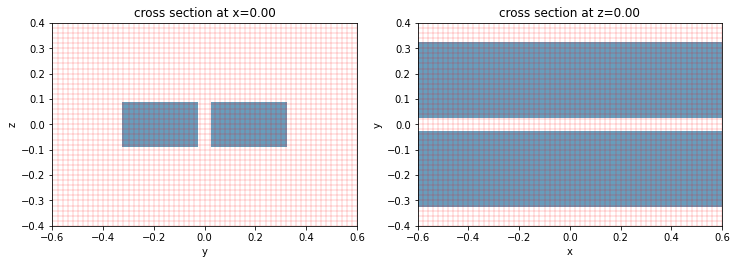

In [4]:
sim_uniform = td.Simulation(
    size=[5, 3, 3],
    grid_spec=td.GridSpec.uniform(dl=20*nm),
    medium=sub_med,
    structures=[box1, box2],
    boundary_spec=boundary_spec,
    run_time=1e-12
)

plot_sim_grid(sim_uniform);

## Automatic nonuniform grid

By default, Tidy3D uses a more advanced meshing, using an algorithm to automatically define a nonuniform grid in all three directions. The resolution of this grid is specified using the desired minimum steps per wavelength in each material (`min_steps_per_wvl = 10` by default). This specification therefore requires a target wavelength, which can be either provided directly to `grid_spec`, or inferred from any sources present in the simulation. The two simulations below will have the same grid.

           WARNING  No sources in simulation.                               ]8;id=143956;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=938129;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#435\435]8;;\

           INFO     Auto meshing using wavelength 1.5500 defined from        ]8;id=163493;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=81398;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#466\466]8;;\
                    sources.                                                                 

Total number of grid points (millions): 0.53


<Figure size 864x432 with 2 Axes>

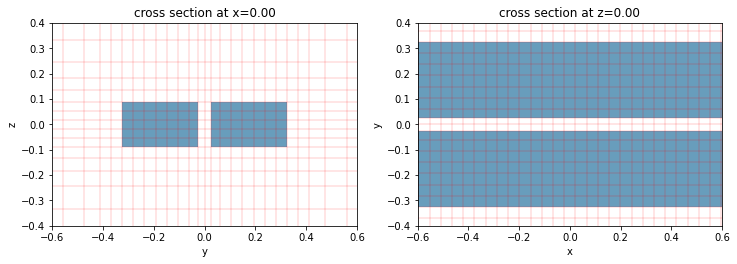

In [5]:
# provide wavelength directly
sim_nonuniform_10 = td.Simulation(
    size=[5, 3, 3],
    grid_spec=td.GridSpec.auto(wavelength=wavelength),
    medium=sub_med,
    structures=[box1, box2],
    boundary_spec=boundary_spec,
    run_time=1e-12
)

# no grid_spec defined; using default with wavelength taken from source
source = td.ModeSource(
    center=(-2, 0, 0),
    size=(0, 2, 2),
    mode_index=0,
    direction="+",
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10)
)
sim_nonuniform_10 = td.Simulation(
    size=[5, 3, 3],
    medium=sub_med,
    structures=[box1, box2],
    boundary_spec=boundary_spec,
    run_time=1e-12,
    sources=[source],
)

ax = plot_sim_grid(sim_nonuniform_10)

The default grid is somewhat coarse, but it is often good for initial simulations. We can easily refine it by requiring a higher number of steps per wavelength:

           WARNING  No sources in simulation.                               ]8;id=200376;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=466517;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#435\435]8;;\

Total number of grid points (millions): 2.3


<Figure size 864x432 with 2 Axes>

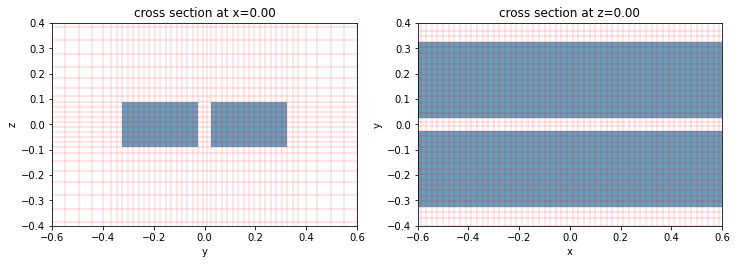

In [6]:
sim_nonuniform_20 = td.Simulation(
    size=[5, 3, 3],
    grid_spec=td.GridSpec.auto(
        wavelength=wavelength,
        min_steps_per_wvl=20,
    ),
    medium=sub_med,
    structures=[box1, box2],
    boundary_spec=boundary_spec,
    run_time=1e-12
)
ax = plot_sim_grid(sim_nonuniform_20)

Notice how the automatic grid conforms to the structures in the simulation, and the grid steps are high in the high-index regions. For this particular problem, we may want to do a final refinement around the slot, where we expect the fields to be strongest. This can be achieved by adding `override_structures` to the simulation `grid_spec`. This is a list of Tidy3D structures each with an arbitrary geometry and medium which are used exclusively for the meshing, added on top of any physical simulation structures.

           WARNING  No sources in simulation.                               ]8;id=565117;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=573463;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#435\435]8;;\

Total number of grid points (millions): 4.0


<Figure size 864x432 with 2 Axes>

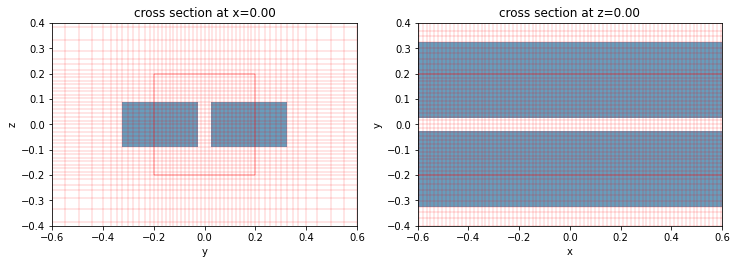

In [7]:
# Define a "dummy" box with refractive index 5 around the central location of the waveguide
refine_box = td.Structure(
    geometry=td.Box(center=(0, 0, 0), size=(td.inf, 0.4, 0.4)),
    medium=td.Medium(permittivity=5 ** 2),
)

# Use the box as a grid refinement structure
sim_nonuniform_20_refine = td.Simulation(
    size=[5, 3, 3],
    grid_spec=td.GridSpec.auto(
        wavelength=wavelength,
        min_steps_per_wvl=20,
        override_structures=[refine_box],
    ),
    medium=sub_med,
    structures=[box1, box2],
    boundary_spec=boundary_spec,
    run_time=1e-12
)

ax = plot_sim_grid(sim_nonuniform_20_refine)

Note that the override region is highlighted in the grid plotting. Now this looks pretty good - the grid size of the points around the slot region is `1550 / 20 / 5 = 15.5` nanometers, while overall the simulation has twice fewer total number of grid points (`4.1M`) compared to the simulation with a uniform mesh step of `20` nanometers (`8.3M`). Just for fun, we can also have a look at the modes of this structure.

<Figure size 864x1008 with 12 Axes>

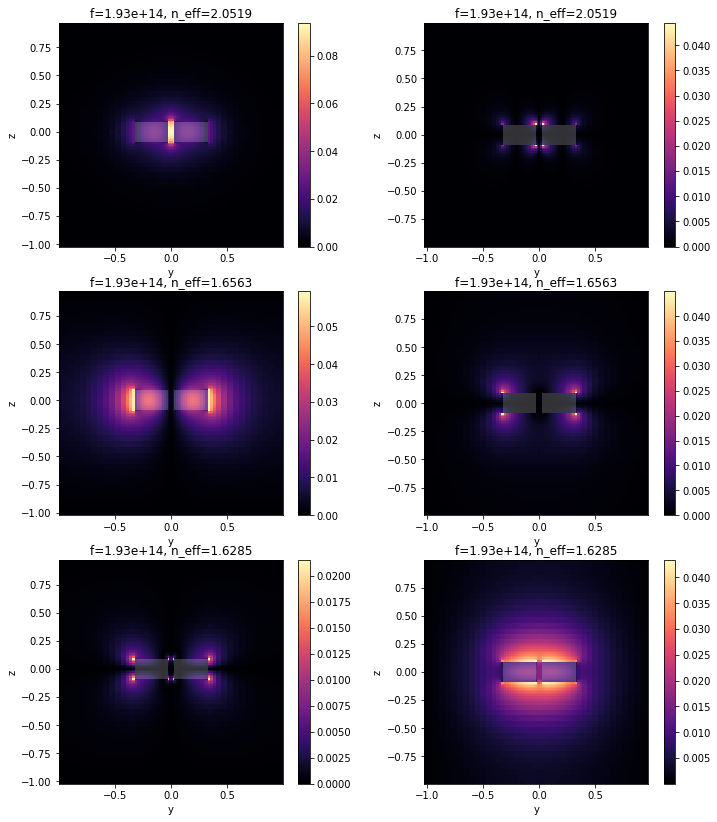

In [8]:
num_modes = 3
plane = td.Box(center=(0, 0, 0), size=(0, 2, 2))
mode_spec=td.ModeSpec(num_modes=num_modes)
ms = ModeSolver(simulation=sim_nonuniform_20_refine, plane=plane, mode_spec=mode_spec, freqs=[freq0])
modes = ms.solve()
fig, axs = plt.subplots(num_modes, 2, figsize=(12, 14))
for mode_ind in range(num_modes):
    modes.plot_field("Ey", "abs", freq=freq0, mode_index=mode_ind, ax=axs[mode_ind, 0], robust=False)
    modes.plot_field("Ez", "abs", freq=freq0, mode_index=mode_ind, ax=axs[mode_ind, 1], robust=False)

## Combination of uniform and nonuiform grid

One last thing to note is that our refinement structure had the unexpected effect of making the mesh along the propagation direction very fine. In the most general case, we can define different grid specifications along each of the three simulation directions. For example, we can set a fixed grid size of `40nm` along the propagation direction, where we expect the field dependence to be smooth, while still using the refined nonuniform mesh in the other two directions.

[16:42:34] WARNING  No sources in simulation.                               ]8;id=769602;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=862718;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#435\435]8;;\

Total number of grid points (millions): 1.7


<Figure size 864x432 with 2 Axes>

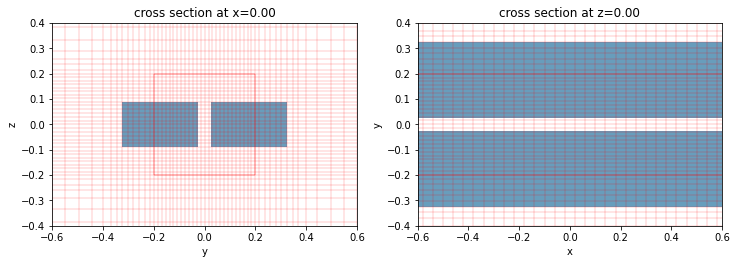

In [9]:
grid_spec = td.GridSpec(
    grid_x = td.UniformGrid(dl=0.04),
    grid_y = td.AutoGrid(min_steps_per_wvl=20),
    grid_z = td.AutoGrid(min_steps_per_wvl=20),
    wavelength=wavelength,
    override_structures=[refine_box]
)

sim_nonuniform_yz_uniform_x = td.Simulation(
    size=[5, 3, 3],
    grid_spec=grid_spec,
    medium=sub_med,
    structures=[box1, box2],
    boundary_spec=boundary_spec,
    run_time=1e-12
)

ax = plot_sim_grid(sim_nonuniform_yz_uniform_x)

The grid in the `yz`-plane is the same as in the previous plot, but the total number of grid points is more than twice fewer!